<img src="http://studioghiblimovies.com/wp-content/uploads/2018/01/152.jpg"  width="1000">
Studio Ghibli, Spirited Away

<h1 align="center"><font size="5">ANIME RECOMMENDATION SYSTEM</font></h1>

Restricted Boltzmann Machine (RBM) are often used to build a Collaborative Filtering based recommendation system. We assume that the users with shared opinions, more likely will have similar preferences. In this notebook we use Kaggle <a href="https://www.kaggle.com/CooperUnion/anime-recommendations-database">Anime Recommendations</a> dataset to demonstrate simple usecase of RBM.

In [1]:
# download data
#!pip install kaggle
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('CooperUnion/anime-recommendations-database', path='data/anime/', unzip=True)

In [ ]:
import tensorflow as tf
tf.__version__

In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Exploring dataset</h3>

This data set contains information on user preference data from 73,516 users on 12,294 anime.

In [5]:
# load anime.csv
anime=pd.read_csv('data/anime/anime.csv')
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Anime.csv
<ol>
    <li>anime_id - myanimelist.net's unique id identifying an anime.</li>
    <li>name - full name of anime.</li>
    <li>genre - comma separated list of genres for this anime.</li>
    <li>type - movie, TV, OVA, etc.</li>
    <li>episodes - how many episodes in this show. (1 if movie).</li>
    <li>rating - average rating out of 10 for this anime.</li>
    <li>members - number of community members that are in this anime's "group".</li>
</ol>

In [33]:
# load ratings
ratings=pd.read_csv('data/anime/rating.csv')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [34]:
ratings_all = ratings

Rating.csv
<ol>
    <li>user_id - non identifiable randomly generated user id.</li>
    <li>anime_id - the anime that this user has rated.</li>
    <li>rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).</li>

In [7]:
# let's check the set of anime in ratings is the same as in anime dataframe
anime_list=anime['anime_id'].unique()
ratings_anime_list=ratings['anime_id'].unique()
set(ratings_anime_list).difference(anime_list)

{20261, 30913, 30924}

There three anime that are in ratings dataframe but are not present in anime list. Let's remove those ratings from dataframe.

In [8]:
ratings=ratings[~ratings['anime_id'].isin([20261, 30913, 30924])]

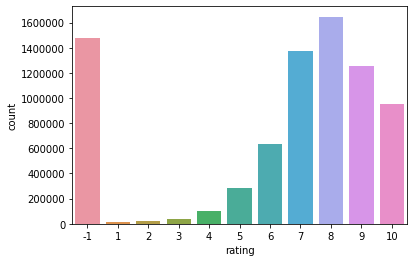

In [9]:
#!pip install seaborn
# Let's see the distrubution of ratings
import seaborn as sns
sns.countplot(x="rating", data=ratings)

As we can see there is significant amount of data with rating "-1". This is "uknown" or missing data which cannot be used for training model because the purpose of our model will be assign each anime with probablity score in the range from 0 to 1.

In [39]:
# drop the "-1" rating observations
ratings=ratings[ratings.rating != -1]
# check the remaining rating scores
ratings.rating.unique()

array([10,  8,  6,  9,  7,  3,  5,  4,  1,  2], dtype=int64)

<h3>Formatting data</h3>

First, convert the dataset into sparse matrix representing users (rows) and their rating for anime (columns).

In [40]:
ratings=ratings.pivot_table(index='user_id',columns='anime_id',values='rating')

In [12]:
ratings.shape

(69600, 9926)

In [13]:
ratings.tail()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
73512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73513,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73515,10.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's normalise data by dividing dataframe by maximum raiting score 10.

In [14]:
trX=(ratings.fillna(0)/10.0).values
trX[-5:]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.9, 0.8, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 1. , 1. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

Set model parameters

In [15]:
# model parameters
hiddenUnits = 50
visibleUnits =  len(ratings.columns)
vb = tf.compat.v1.placeholder("float", [visibleUnits]) # number of unique anime
hb = tf.compat.v1.placeholder("float", [hiddenUnits]) # number of features we're going to learn
W = tf.compat.v1.placeholder("float", [visibleUnits, hiddenUnits])

In [16]:
# input processing
v0 = tf.compat.v1.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.compat.v1.random_uniform(tf.shape(_h0))))
# input reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.compat.v1.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [17]:
# learning rate
alpha = 1.0
# create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
# calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.cast(tf.shape(v0)[0],'float32')
# create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)
# create optimisation fucntion
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [19]:
## initialise weights
# current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
# current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
# current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
# previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
# previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
# previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

0.010947758
0.010623297
0.010466207
0.010348541
0.0102789495
0.010250121
0.010204479
0.010228517
0.010192972
0.010203219


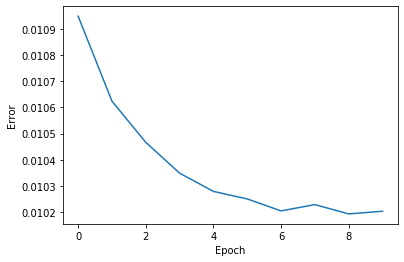

In [20]:
# train the model
epochs =10
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

<h3>Recommendations</h3>

In [116]:
# select user
mock_user_id = 50
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser

array([[0.8, 0. , 0.9, ..., 0. , 0. , 0. ]])

In [117]:
# reconstructing input for selected user
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [143]:
# find all higest scored anime for selected user in reconstructed input
scored_anime_mock = anime[anime['anime_id'].isin(ratings.columns)]
scored_anime_mock = scored_anime_mock.assign(RecommendationScore = rec[0])
scored_anime_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,anime_id,name,genre,type,episodes,rating,members,RecommendationScore
821,3515,Saint Seiya: Meiou Hades Elysion-hen,"Action, Fantasy, Shounen, Super Power",OVA,6,7.82,19044,0.832549
1404,17269,Captain Harlock,"Action, Drama, Sci-Fi, Space",Movie,1,7.56,25484,0.792952
225,5681,Summer Wars,"Comedy, Sci-Fi",Movie,1,8.30,223359,0.746365
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,0.674371
1419,9366,Kaichou wa Maid-sama!: Omake dayo!,"Comedy, School, Shoujo",Special,1,7.55,52752,0.670489
51,3297,Aria The Origination,"Fantasy, Sci-Fi, Shounen, Slice of Life",TV,13,8.64,56162,0.658597
53,6114,Rainbow: Nisha Rokubou no Shichinin,"Drama, Historical, Seinen, Thriller",TV,26,8.64,139474,0.610382
2092,16868,Sukitte Ii na yo.: Dareka ga,"Romance, School, Shoujo",OVA,1,7.36,27802,0.603869
187,28675,Kyoukai no Kanata Movie: I&#039;ll Be Here - M...,"Fantasy, Slice of Life, Supernatural",Movie,1,8.35,59815,0.577502
52,30709,Kamisama Hajimemashita: Kako-hen,"Comedy, Demons, Fantasy, Shoujo, Supernatural",OVA,4,8.64,33422,0.573790


In [139]:
# find 'TV' type anime that user has already watched
anime_user = ratings_all[ratings_all['user_id']==mock_user_id]
anime_user_mock = anime.merge(anime_user, on='anime_id', how='inner')
anime_user_mock[anime_user_mock['type']=='TV'].sort_values(['rating_y'],ascending=False).head(20)

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,50,10
8,19,Monster,"Drama, Horror, Mystery, Police, Psychological,...",TV,74,8.72,247562,50,10
50,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297,50,10
35,223,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",TV,153,8.16,316102,50,10
24,6811,InuYasha: Kanketsu-hen,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",TV,26,8.37,99128,50,10
13,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229,50,10
11,16894,Kuroko no Basket 2nd Season,"Comedy, School, Shounen, Sports",TV,25,8.58,243325,50,10
1,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,50,10
2,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,50,10
6,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,50,10


In [140]:
# Recommend top 10 anime for selected user
merged_mock = scored_anime_mock.merge(anime_user, on='anime_id', how='outer')
merged_mock[merged_mock['type']=='TV'].sort_values(["RecommendationScore"], ascending=False).head(10)

,anime_id,name,genre,type,episodes,RecommendationScore,user_id,rating
50,3297,Aria The Origination,"Fantasy, Sci-Fi, Shounen, Slice of Life",TV,13,0.658597,NaN,NaN
52,6114,Rainbow: Nisha Rokubou no Shichinin,"Drama, Historical, Seinen, Thriller",TV,26,0.610382,NaN,NaN
3936,19429,Akuma no Riddle,"Action, School, Shoujo Ai",TV,12,0.553567,NaN,NaN
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,0.468722,50.0,9.0
1099,8841,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,0.442839,NaN,NaN
1426,15731,Tamayura: More Aggressive,"Comedy, Drama, Slice of Life",TV,12,0.429213,NaN,NaN
4656,31560,Miss Monochrome: The Animation 3,"Comedy, Music, Slice of Life",TV,13,0.414161,NaN,NaN
22,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,0.395089,50.0,10.0
13,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,0.359009,50.0,9.0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,0.352421,NaN,NaN


Witing top 10 recommended anime there are highly rated anime series that user has already watched which indicates good prediction result.

This concludes the simple use case of RMB for recommendation system.